In [2]:
!python -m pip install --index-url https://support.bayesfusion.com/pysmile-A/ pysmile

Looking in indexes: https://support.bayesfusion.com/pysmile-A/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import itertools
import pysmile
import pprint

from collections import Counter


In [4]:
sns.set_style("whitegrid")

In [5]:
pysmile.License((
	b"SMILE LICENSE 2c4f954d 72216c8d e0e08fa1 "
	b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
	b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
	b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
	b"SOFTWARE LICENSING AGREEMENT. "
	b"Serial #: 6elhdnh8czmjbetdjhpo4d5vl "
	b"Issued for: Jaime Perez (jaime.perez.sanchez@gmail.com) "
	b"Academic institution: Universidad Pontificia Comillas "
	b"Valid until: 2023-11-17 "
	b"Issued by BayesFusion activation server"
	),[
	0x65,0x83,0x6e,0x39,0x81,0x24,0xbf,0x37,0x03,0x5e,0xb5,0x21,0xf1,0x77,0x2e,0x56,
	0xab,0x6b,0x43,0x35,0x23,0x31,0xa9,0xaf,0x98,0x23,0x48,0xae,0x87,0x60,0x02,0x1c,
	0xf5,0x6e,0x83,0x2d,0x47,0xda,0x5f,0x65,0x10,0xf3,0x4c,0x38,0x7c,0x71,0x19,0x20,
	0x00,0x27,0x04,0x9f,0x53,0x8a,0xe5,0x95,0x27,0xc1,0xa7,0xbd,0xa4,0x2b,0xd0,0xb2])

In [6]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
# from google_drive_downloader import GoogleDriveDownloader as gdd



# gdd.download_file_from_google_drive(file_id='1LkG3-BPtIVAgKzFw8Y3ZtqjABnWyGLMw',
#                                    dest_path='./DAG_OG_v2_trained.xdsl',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1xMCNz9Ay7SID6fHuoOTOshdBGB6VUXAw',
#                                    dest_path='./DAG_FN_v2_trained.xdsl',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1ofhqAkI6o0DBoVptThBdczvvAvsIuCW4',
#                                    dest_path='./DAG_CT_v2_trained.xdsl',
#                                    unzip=False)

In [9]:
# gdd.download_file_from_google_drive(file_id='1ejOgdFDoO-DJcBNvb0EznLIq3bDZAAoN',
#                                    dest_path='./data_DAG_OG_v2.csv',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1hEHwxbIxOUBXsfwDBrUNgI7zCHlmxJDd',
#                                    dest_path='./data_DAG_FN_v2.csv',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1p4Pd0M8sdQtcIC3dNrZ3nxdTXSezvK2z',
#                                    dest_path='./data_DAG_CT_v2.csv',
#                                    unzip=False)

In [10]:
normalization = math.sqrt(math.log(2))

In [11]:
network_file_OG = "DAG_OG_v2_trained.xdsl"
var_interest_OG = 'OG_risk'

network_file_FN = "DAG_FN_v2_trained.xdsl"
var_interest_FN = 'FN_risk'

network_file_CT = "DAG_CT_v2_trained.xdsl"
var_interest_CT = 'CT_risk'

In [12]:
def compute_rank_evidencesv2(num, values, DAG_file, var_interest):
  num_var = num
  dict_val = values
  net = pysmile.Network()
  net.read_file(DAG_file)
  net.update_beliefs()

  dict_results = {}
  dict_results_prob_ev = {}
  dict_results_norm = {}

  lst_groups = list(itertools.combinations(list(dict_val.keys()), num_var))

  for group in lst_groups:
    lst_values = [dict_val[val] for val in group]
    lst_iter = list(itertools.product(*lst_values))
    for subgroup in lst_iter:
      net.clear_all_evidence()
      # Set evidences
      for i in range(num_var):
        net.set_evidence(group[i], subgroup[i])
      # Update beleifs and get value
      net.update_beliefs()
      beliefs = net.get_node_value(var_interest)
      key_ = tuple(sorted([group[i]+str(subgroup[i]) for i in range(num_var)]))
      dict_results[key_] = beliefs[1]
      prob_e = net.prob_evidence()
      dict_results_prob_ev[key_] = prob_e
      dict_results_norm[key_] = beliefs[1]*prob_e/0.1

  df_ = pd.DataFrame.from_dict(dict_results, orient='index', columns=['P(Riksy|Evidence)'])
  df_prob_ev = pd.DataFrame.from_dict(dict_results_prob_ev, orient='index', columns=['P(Evidence)'])
  df_norm = pd.DataFrame.from_dict(dict_results_norm, orient='index', columns=['P(Evidence|Risky)'])
  df_extra_ = df_norm.join(df_prob_ev)
  df_extra = df_extra_.join(df_)
  return df_extra

In [13]:
def compute_rank_evidences(num, values):
  num_var = num
  dict_val = values
  net = pysmile.Network()
  net.read_file(network_file)
  net.update_beliefs()

  dict_results = {}
  dict_results_prob_ev = {}
  dict_results_norm = {}

  lst_groups = list(itertools.combinations(list(dict_val.keys()), num_var))

  for group in lst_groups:
    lst_values = [dict_val[val] for val in group]
    lst_iter = list(itertools.product(*lst_values))
    for subgroup in lst_iter:
      net.clear_all_evidence()
      # Set evidences
      for i in range(num_var):
        net.set_evidence(group[i], subgroup[i])
      # Update beleifs and get value
      net.update_beliefs()
      beliefs = net.get_node_value(var_interest)
      key_ = tuple(sorted([group[i]+str(subgroup[i]) for i in range(num_var)]))
      dict_results[key_] = beliefs[1]
      prob_e = net.prob_evidence()
      dict_results_prob_ev[key_] = prob_e
      dict_results_norm[key_] = beliefs[1]*prob_e/0.1

  df_ = pd.DataFrame.from_dict(dict_results, orient='index', columns=['P(Riksy|Evidence)'])
  df_prob_ev = pd.DataFrame.from_dict(dict_results_prob_ev, orient='index', columns=['P(Evidence)'])
  df_norm = pd.DataFrame.from_dict(dict_results_norm, orient='index', columns=['P(Evidence|Risky)'])
  df_extra_ = df_norm.join(df_prob_ev)
  df_extra = df_extra_.join(df_)
  return df_extra

In [14]:
def plot_var_count(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>threshold].index:
    all_indexes.extend(i)

  len_df_filtered = len(df[df[var]>threshold])
  lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
  df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
  df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_count, x='Percentage', y='Variable')
  plt.xlim((0,100))

  # plt.xticks(rotation=90)
  plt.show()

In [93]:
df_DAG_OG.Openness2Experience_BF.value_counts()

0    613
1    451
2    237
Name: Openness2Experience_BF, dtype: int64

In [102]:
def plot_var_count_elegant(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>threshold].index:
    all_indexes.extend(i)

  len_df_filtered = len(df[df[var]>threshold])
  lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
  df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
  df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

  dict_var_names = {'Previous_Victimization0': 'Previous Victimization = False',
                    'Honesty0': 'Honesty = Low',
                    'Honesty1': 'Honesty = Medium Low',
                    'Honesty2': 'Honesty = Medium',
                    'Honesty3': 'Honesty = High',
                    'Neuroticism_BF0': 'Neuroticism = Low',
                    'Neuroticism_BF1': 'Neuroticism = Medium',
                    'Neuroticism_BF2': 'Neuroticism = High',
                    'Conscientiousness_BF0': 'Conscientiousness = Low',
                    'Conscientiousness_BF1': 'Conscientiousness = Medium',
                    'Conscientiousness_BF2': 'Conscientiousness = High',
                    'Agreeableness_BF0': 'Agreeableness = Low',
                    'Agreeableness_BF1': 'Agreeableness = Medium',
                    'Agreeableness_BF2': 'Agreeableness = High',
                    'Introversion_BF0': 'Introversion = Low',
                    'Introversion_BF1': 'Introversion = Medium',
                    'Introversion_BF2': 'Introversion = High',
                    'Openness2Experience_BF0': 'Openness2Experience = Low',
                    'Openness2Experience_BF1': 'Openness2Experience = Medium',
                    'Openness2Experience_BF2': 'Openness2Experience = High',
                  'Previous_Victimization1': 'Previous Victimization = True',
                  'Gender0': 'Gender = Male',
                  'Gender1': 'Gender = Female',
                  'Gender2': 'Gender = Non Binary',
                  'Social_Support0': 'Social Support = Low',
                  'Social_Support1': 'Social Support = Medium',
                  'Social_Support2': 'Social Support = High',
                  'Family_Support0': 'Family Support = Low',
                  'Family_Support1': 'Family Support = Medium',
                  'Family_Support2': 'Family Support = High',
                  'Age0': 'Age = 12',
                  'Age1': 'Age = 13',
                  'Age2': 'Age = 14',
                  'Age3': 'Age = 15',
                  'Age4': 'Age = 16',
                  'Self_Esteem0': 'Self-Esteem = Low',
                  'Self_Esteem1': 'Self-Esteem = Medium',
                  'Self_Esteem2': 'Self-Esteem = High',
                  'Empathy0': 'Empathy = Low',
                  'Empathy1': 'Empathy = High',
                  'Migratory_background0': 'Migratory background = No',
                  'Migratory_background1': 'Migratory background = 2nd Gen.',
                  'Migratory_background2': 'Migratory background = 3rd Gen.',
                  'Sexual_Orientation0': 'Sexual Orientation = Heterosexual',
                  'Sexual_Orientation1': 'Sexual Orientation = Non Heterosexual',
                  'Hours_Internet0': 'Hours Internet = <1h',
                  'Hours_Internet1': 'Hours Internet = 1-2h',
                  'Hours_Internet2': 'Hours Internet = 2-3h',
                  'Hours_Internet3': 'Hours Internet = 3-4h',
                  'Hours_Internet4': 'Hours Internet = >4h'
                  }
  df_count_elegant = df_count.replace(dict_var_names)
  plt.figure(figsize=(10, 7))
  sns.barplot(data=df_count_elegant, x='Percentage', y='Variable', color='tab:blue')

  plt.xlim((0,100))
  # plt.savefig("5_Factors.pdf", format="pdf", bbox_inches="tight")
  # plt.xticks(rotation=90)
  plt.show()

In [16]:
def plot_var_count_2(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>0.25].index:
    all_indexes.extend(i)

  set_all_indexes = set(all_indexes)
  len_df_filtered = len(df[df['P(Riksy|Evidence)']>0.25])

  lst_percentage_2 = []
  for value in set_all_indexes:
    mask=[]
    for idx in df.index:
      mask.append(value in idx)
    df_tmp = df[mask]
    lst_percentage_2.append(df_tmp['P(Evidence)'].sum())

  df_count_ = pd.DataFrame(list(zip(lst_percentage_2, set_all_indexes)), columns=['Sum_Prob_evidences', 'Variable'])
  df_count = df_count_.sort_values(by=['Sum_Prob_evidences'], ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_count, x='Sum_Prob_evidences', y='Variable')

  # plt.xticks(rotation=90)
  plt.show()

## Game Questions


In [17]:
df_DAG_CT = pd.read_csv("data_DAG_CT_v2.csv")
df_DAG_FN = pd.read_csv("data_DAG_FN_v2.csv")
df_DAG_OG = pd.read_csv("data_DAG_OG_v2.csv")

In [18]:
dict_val_game = {'A1_1_PhotoSharing': [0,1],
                  'A1_2_Sociable': [0,1],
                  'A1_3_MatthewMeme': [0,1,2],
                  'A2_1_name': [0,1,2,3],
                  'A2_2_pass': [0,1,2],
                  'A2_3_prof_type': [0,1],
                  'A2_4_place': [0,1,2,3],
                  'A2_5_prof_photo': [0,1,2],
                  'A2_7_usepc': [0,1],
                  'A2_8_friend_rq': [0,1,2],
                  'A2_9_photos': [0,1],
                  'A2_10_photos_nk': [0,1],
                  'A2_11_photos_nkplus': [0,1],
                  'A2_12_ask_help': [0,1],
                  'A2_13_close_case': [0,1],
                  'A2_14_tell_parents': [0,1,2],
                  'A2_15_block_prof': [0,1],
                  'A3_1_pirated_Content': [0,1],
                  'A3_2_Pol_Pola': [0,1,2],
                  'A3_3_time_overrun': [0,1],
                  'A3_4_Pol_Bullied': [0,1,2],
                  'A3_5_remind_Matthew': [0,1,2],
                  'A3_6_Talk_Pol': [0,1],
                  'A3_7_Help_Pol': [0,1,2,3],
                  'A4_1_phishing': [0,1],
                  'A4_2_pass': [0,1,2],
                  'A4_3_stolen': [0,1],
                  'A4_4_other_stolen': [0,1],
                  'A5_1_secret': [0,1],
                  'A5_2_biology': [0,1],
                  'A5_3_sheila': [0,1],
                  'A6_1_news_check': [0,1,2,3],
                  'A6_2_look': [0,1],
                  'A6_3_source': [0,1],
                  'A6_4_accu': [0,1],
                  'A6_5_replay_post': [0,1],
                  'A6_6_regarding_charles': [0,1]}

In [19]:
dict_val_game_CT = { 'A2_2_pass': [0,1,2],
                  'A3_1_pirated_Content': [0,1],
                  'A4_1_phishing': [0,1],
                  'A4_2_pass': [0,1,2],
                  'A4_3_stolen': [0,1],
                  'A4_4_other_stolen': [0,1]}

### 1 variable analysis


In [20]:
df_q_1_join_ = compute_rank_evidencesv2(1, dict_val_game_CT, network_file_CT, var_interest_CT)
df_q_1_join = df_q_1_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_1_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A4_2_pass2,)",0.252031,0.641545,0.039285
"(A2_2_pass2,)",0.625387,0.548596,0.113998
"(A4_1_phishing1,)",1.010783,0.578190,0.174819
"(A4_3_stolen1,)",1.557052,0.783416,0.198752
"(A3_1_pirated_Content1,)",1.482189,0.673891,0.219945
"(A4_4_other_stolen1,)",1.685635,0.734346,0.229542
"(A2_2_pass1,)",1.259299,0.293671,0.428812
"(A3_1_pirated_Content0,)",1.527915,0.326109,0.468530
"(A4_1_phishing0,)",1.999321,0.421810,0.473986
"(A4_4_other_stolen0,)",1.324470,0.265654,0.498569


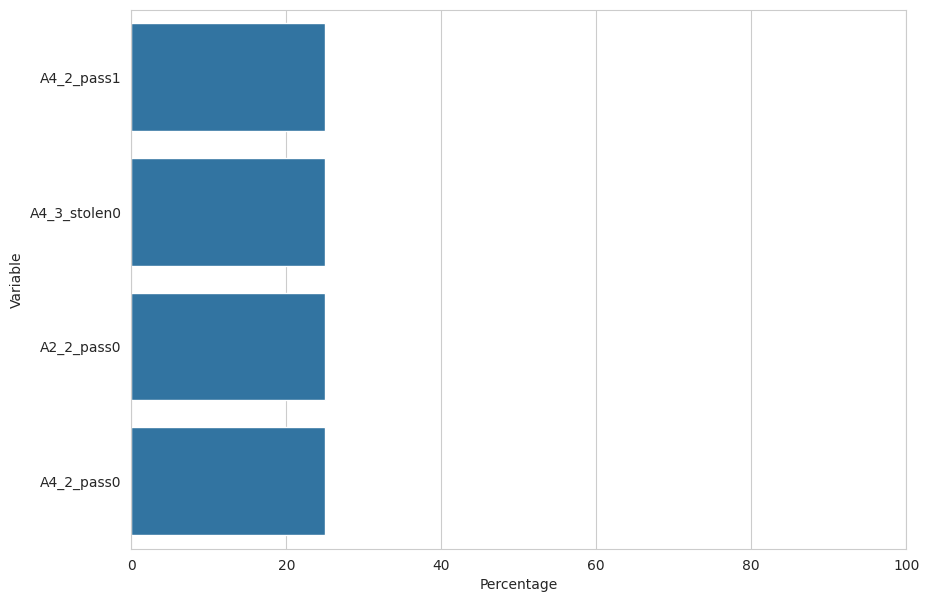

In [95]:
plot_var_count_elegant(df=df_q_1_join, var='P(Riksy|Evidence)', threshold=0.57)

### 2 variable analysis


In [22]:
df_q_2_join_ = compute_rank_evidencesv2(2, dict_val_game_CT, network_file_CT, var_interest_CT)
df_q_2_join = df_q_2_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_2_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_2_pass2, A4_2_pass2)",0.061801,0.434026,0.014239
"(A4_1_phishing1, A4_2_pass2)",0.091981,0.429160,0.021433
"(A4_2_pass2, A4_3_stolen1)",0.128262,0.566116,0.022657
"(A3_1_pirated_Content1, A4_2_pass2)",0.111720,0.473433,0.023598
"(A4_2_pass2, A4_4_other_stolen1)",0.143709,0.512635,0.028033
...,...,...,...
"(A4_1_phishing0, A4_2_pass0)",1.101452,0.113616,0.969454
"(A3_1_pirated_Content0, A4_2_pass0)",0.834041,0.085936,0.970540
"(A4_2_pass0, A4_4_other_stolen0)",0.727653,0.074425,0.977694
"(A4_2_pass0, A4_3_stolen0)",0.793284,0.080393,0.986758


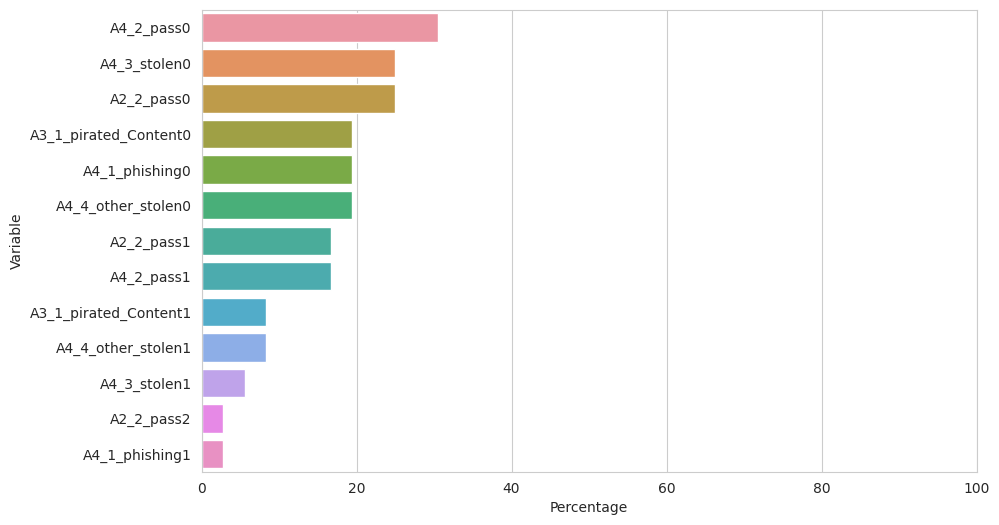

In [96]:
plot_var_count(df=df_q_2_join, var='P(Riksy|Evidence)', threshold=0.57)

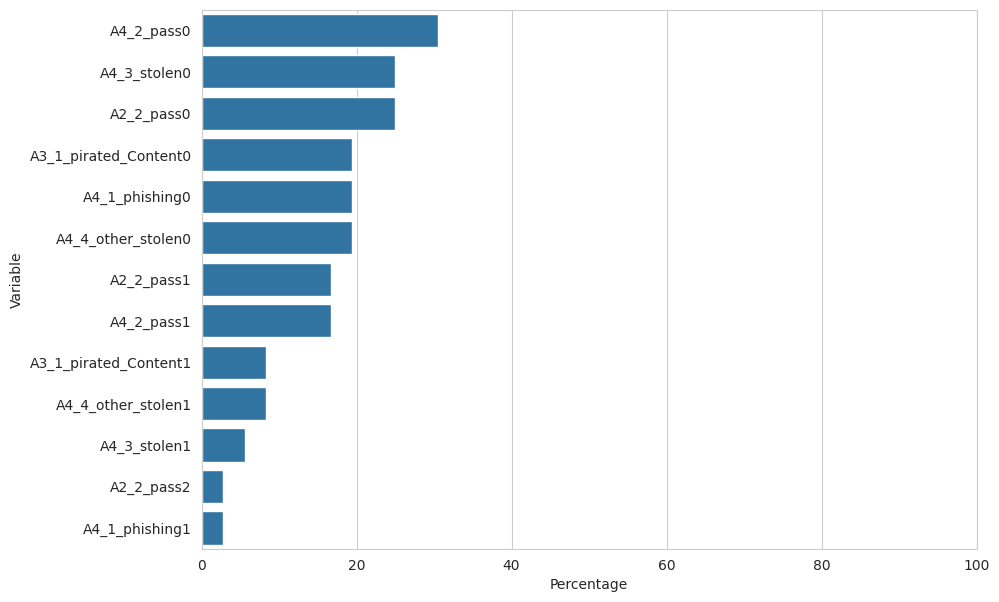

In [97]:
plot_var_count_elegant(df=df_q_2_join, var='P(Riksy|Evidence)', threshold=0.57)

### 3 variable analysis


In [25]:
df_q_3_join_ = compute_rank_evidencesv2(3, dict_val_game_CT, network_file_CT, var_interest_CT)
df_q_3_join = df_q_3_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_3_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_2_pass2, A4_1_phishing1, A4_2_pass2)",0.022989,0.296168,0.007762
"(A2_2_pass2, A4_2_pass2, A4_3_stolen1)",0.031257,0.388595,0.008044
"(A2_2_pass2, A3_1_pirated_Content1, A4_2_pass2)",0.026725,0.326894,0.008175
"(A2_2_pass2, A4_2_pass2, A4_4_other_stolen1)",0.035349,0.352525,0.010027
"(A4_1_phishing1, A4_2_pass2, A4_3_stolen1)",0.046956,0.382445,0.012278
...,...,...,...
"(A4_2_pass0, A4_3_stolen0, A4_4_other_stolen0)",0.356610,0.035873,0.994081
"(A2_2_pass0, A3_1_pirated_Content0, A4_2_pass0)",0.337619,0.033947,0.994555
"(A2_2_pass0, A4_1_phishing0, A4_2_pass0)",0.453515,0.045573,0.995134
"(A2_2_pass0, A4_2_pass0, A4_4_other_stolen0)",0.299373,0.030076,0.995396


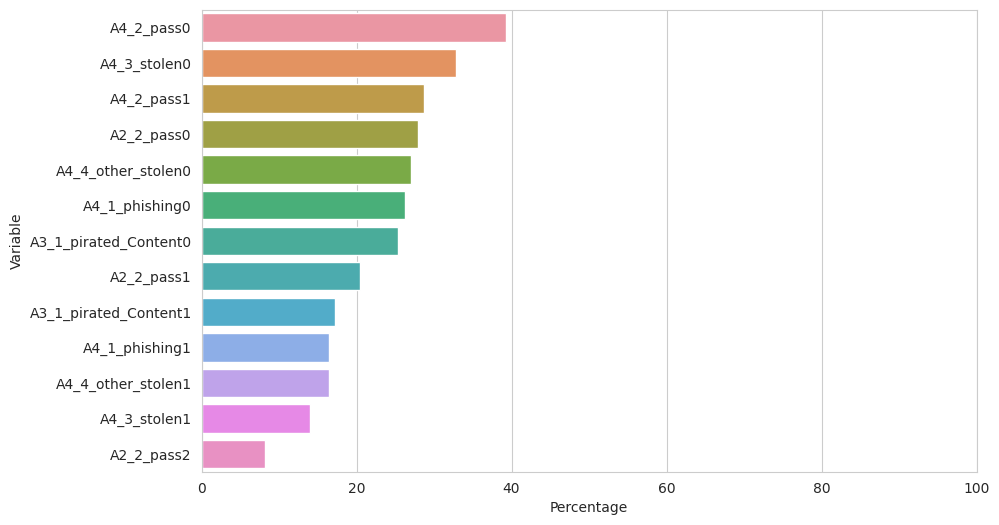

In [100]:
plot_var_count(df=df_q_3_join, var='P(Riksy|Evidence)', threshold=0.57)

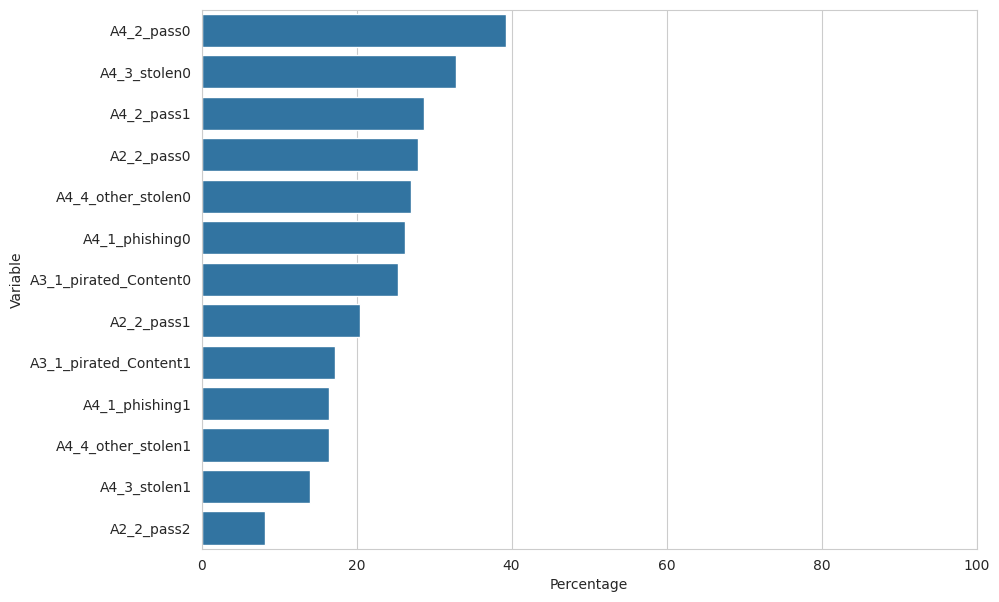

In [101]:
plot_var_count_elegant(df=df_q_3_join, var='P(Riksy|Evidence)', threshold=0.57)

### 4 variable analysis


In [28]:
df_q_4_join_ = compute_rank_evidencesv2(4, dict_val_game_CT, network_file_CT, var_interest_CT)
df_q_4_join = df_q_4_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_4_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_2_pass2, A4_1_phishing1, A4_2_pass2, A4_3_stolen1)",0.011643,0.266323,0.004372
"(A2_2_pass2, A3_1_pirated_Content1, A4_1_phishing1, A4_2_pass2)",0.009911,0.225218,0.004400
"(A2_2_pass2, A3_1_pirated_Content1, A4_2_pass2, A4_3_stolen1)",0.013694,0.294088,0.004656
"(A2_2_pass2, A4_1_phishing1, A4_2_pass2, A4_4_other_stolen1)",0.013193,0.241714,0.005458
"(A2_2_pass2, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.017914,0.316919,0.005653
...,...,...,...
"(A2_2_pass0, A3_1_pirated_Content0, A4_2_pass0, A4_4_other_stolen0)",0.157252,0.015772,0.997037
"(A2_2_pass0, A4_1_phishing0, A4_2_pass0, A4_4_other_stolen0)",0.210769,0.021132,0.997406
"(A2_2_pass0, A3_1_pirated_Content0, A4_2_pass0, A4_3_stolen0)",0.169762,0.017002,0.998470
"(A2_2_pass0, A4_1_phishing0, A4_2_pass0, A4_3_stolen0)",0.227238,0.022755,0.998644


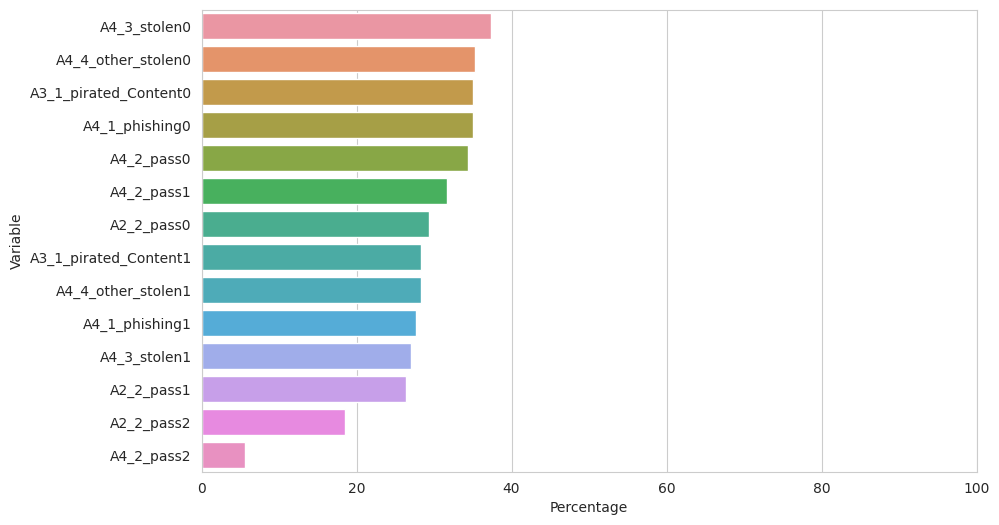

In [29]:
plot_var_count(df=df_q_4_join, var='P(Riksy|Evidence)', threshold=0.25)

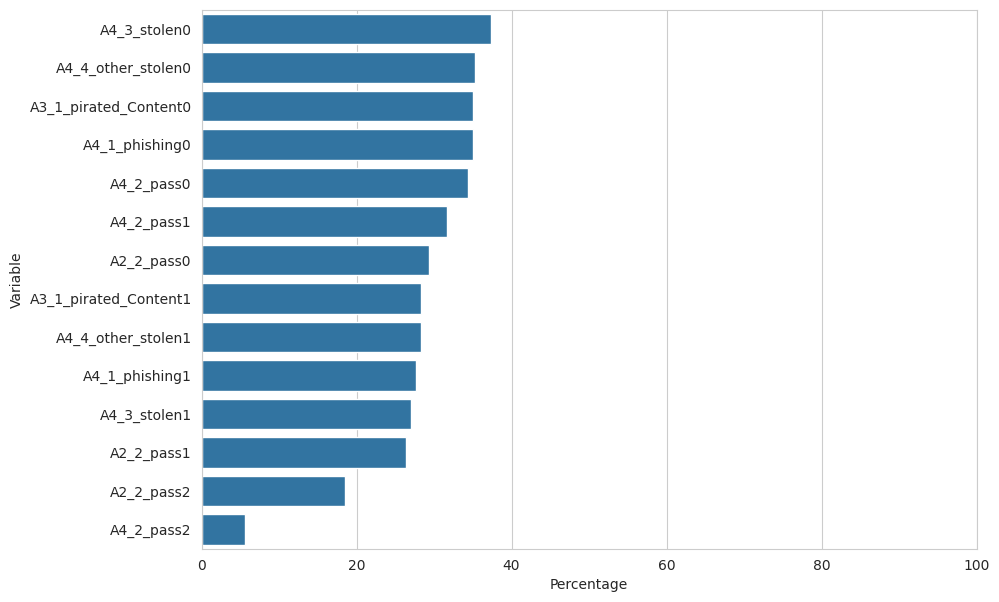

In [30]:
plot_var_count_elegant(df=df_q_4_join, var='P(Riksy|Evidence)', threshold=0.25)

### 5 variable analysis


In [31]:
df_q_5_join_ = compute_rank_evidencesv2(5, dict_val_game_CT, network_file_CT, var_interest_CT)
df_q_5_join = df_q_5_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_5_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_2_pass2, A3_1_pirated_Content1, A4_1_phishing1, A4_2_pass2, A4_3_stolen1)",0.005087,0.203196,0.002503
"(A2_2_pass2, A4_1_phishing1, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.006694,0.218029,0.003070
"(A2_2_pass2, A3_1_pirated_Content1, A4_1_phishing1, A4_2_pass2, A4_4_other_stolen1)",0.005706,0.185298,0.003079
"(A2_2_pass2, A3_1_pirated_Content1, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.007876,0.241906,0.003256
"(A3_1_pirated_Content1, A4_1_phishing1, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.012165,0.235652,0.005162
...,...,...,...
"(A2_2_pass0, A3_1_pirated_Content1, A4_2_pass0, A4_3_stolen0, A4_4_other_stolen0)",0.070478,0.007060,0.998201
"(A2_2_pass0, A3_1_pirated_Content0, A4_1_phishing0, A4_2_pass0, A4_4_other_stolen0)",0.111759,0.011195,0.998290
"(A2_2_pass0, A3_1_pirated_Content0, A4_1_phishing0, A4_2_pass0, A4_3_stolen0)",0.120456,0.012056,0.999105
"(A2_2_pass0, A3_1_pirated_Content0, A4_2_pass0, A4_3_stolen0, A4_4_other_stolen0)",0.079616,0.007968,0.999139


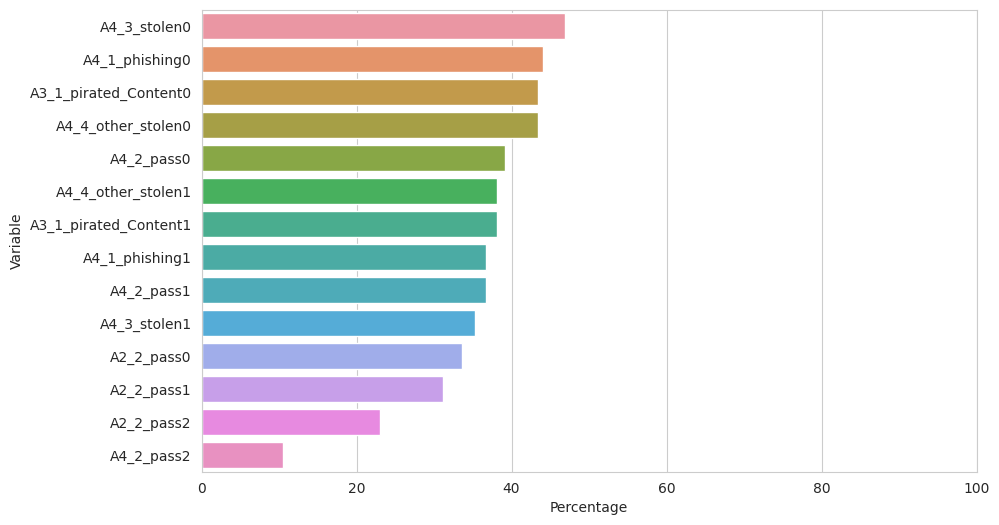

In [32]:
plot_var_count(df=df_q_5_join, var='P(Riksy|Evidence)', threshold=0.25)

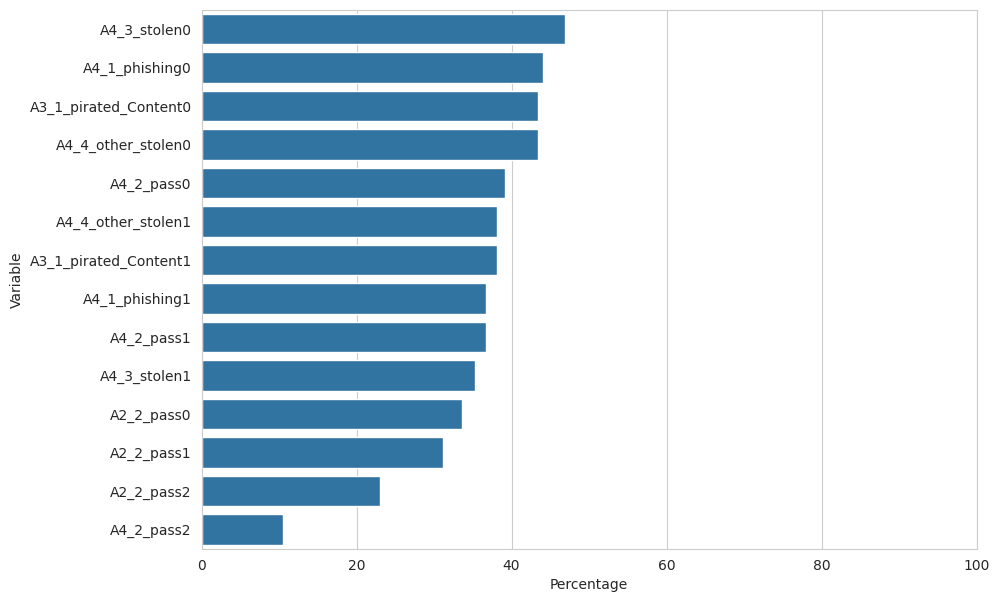

In [33]:
plot_var_count_elegant(df=df_q_5_join, var='P(Riksy|Evidence)', threshold=0.25)

### 6 variable analysis


In [34]:
df_q_6_join_ = compute_rank_evidencesv2(6, dict_val_game_CT, network_file_CT, var_interest_CT)
df_q_6_join = df_q_6_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_6_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_2_pass2, A3_1_pirated_Content1, A4_1_phishing1, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.002935,0.167618,0.001751
"(A2_2_pass2, A3_1_pirated_Content1, A4_1_phishing1, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen0)",0.002152,0.035578,0.006049
"(A2_2_pass2, A3_1_pirated_Content1, A4_1_phishing0, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.004941,0.074288,0.006651
"(A2_2_pass2, A3_1_pirated_Content0, A4_1_phishing1, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.003759,0.050411,0.007457
"(A2_2_pass1, A3_1_pirated_Content1, A4_1_phishing1, A4_2_pass2, A4_3_stolen1, A4_4_other_stolen1)",0.005982,0.054214,0.011035
...,...,...,...
"(A2_2_pass1, A3_1_pirated_Content0, A4_1_phishing0, A4_2_pass0, A4_3_stolen0, A4_4_other_stolen0)",0.047808,0.004791,0.997931
"(A2_2_pass0, A3_1_pirated_Content0, A4_1_phishing1, A4_2_pass0, A4_3_stolen0, A4_4_other_stolen0)",0.022702,0.002274,0.998257
"(A2_2_pass0, A3_1_pirated_Content0, A4_1_phishing0, A4_2_pass0, A4_3_stolen0, A4_4_other_stolen1)",0.063542,0.006362,0.998760
"(A2_2_pass0, A3_1_pirated_Content1, A4_1_phishing0, A4_2_pass0, A4_3_stolen0, A4_4_other_stolen0)",0.049452,0.004950,0.998959


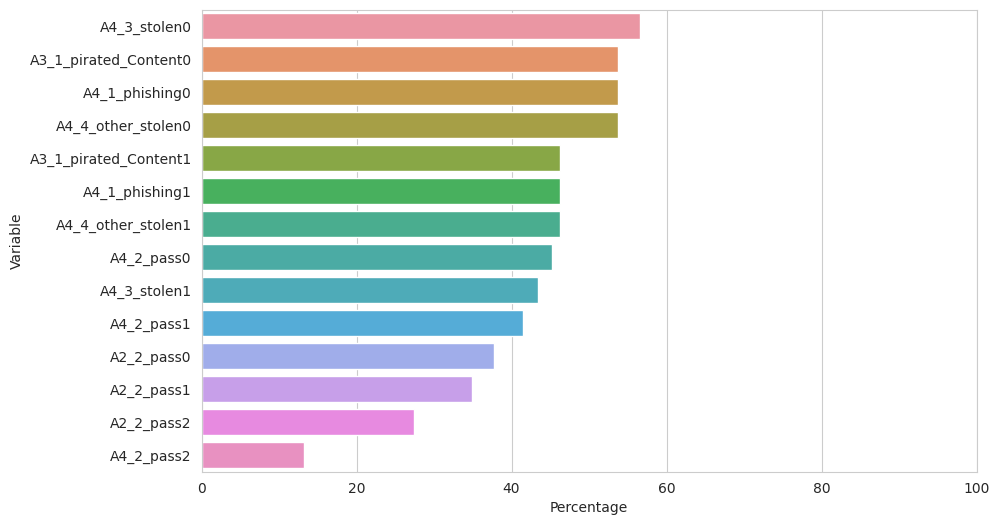

In [84]:
plot_var_count(df=df_q_6_join, var='P(Riksy|Evidence)', threshold=0.25)

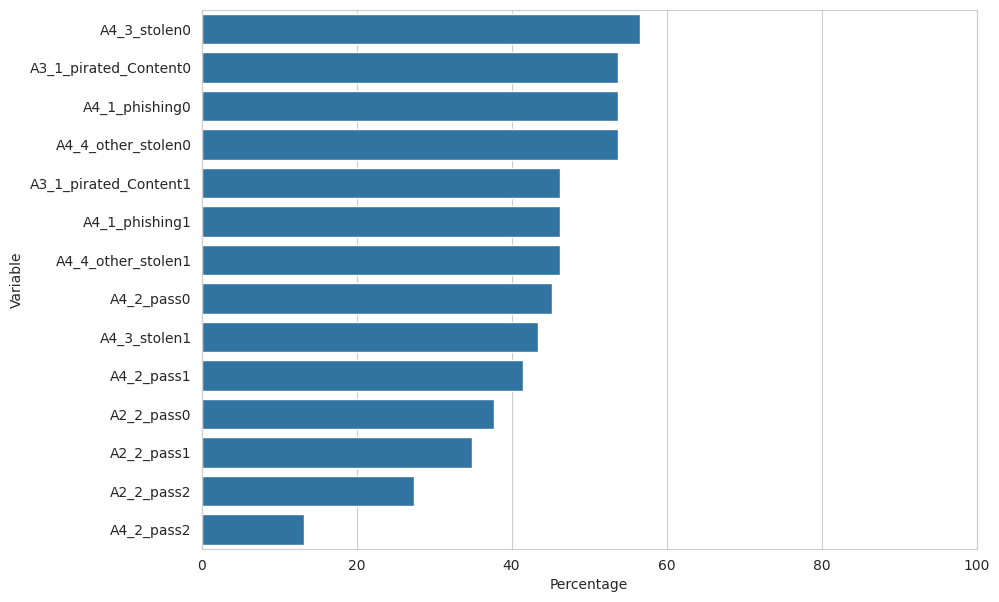

In [36]:
plot_var_count_elegant(df=df_q_6_join, var='P(Riksy|Evidence)', threshold=0.25)

## Demographics


In [37]:
dict_val = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Sexual_Orientation': [0,1],
           'Migratory_background': [0,1],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Self_Esteem': [0,1,2],
           'Empathy': [0,1],
           'Previous_Victimization': [0,1]
           }

dict_val_CT  = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Conscientiousness_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

dict_val_FN = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Conscientiousness_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

dict_val_OG = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Sexual_Orientation': [0,1],
           'Migratory_background': [0,1],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Self_Esteem': [0,1,2],
           'Introversion_BF': [0,1,2],
           'Openness2Experience_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

### 1 variable analysis

In [38]:
df_1_join_ = compute_rank_evidencesv2(1, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_1_join = df_1_join_.sort_values(by=['P(Riksy|Evidence)'])
df_1_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Honesty2,)",0.646676,0.301357,0.214588
"(Honesty3,)",0.473668,0.190684,0.248404
"(Honesty1,)",0.936176,0.320799,0.291826
"(Hours_Internet1,)",0.742015,0.252483,0.293887
"(Gender1,)",1.413459,0.480000,0.294471
"(Age1,)",0.590580,0.200000,0.295290
"(Neuroticism_BF0,)",1.146163,0.383936,0.298530
"(Conscientiousness_BF2,)",0.694571,0.232129,0.299219
"(Agreeableness_BF2,)",0.410128,0.136948,0.299478
"(Social_Support2,)",1.691599,0.564659,0.299579


### 2 variables analysis

In [39]:
df_2_join_ = compute_rank_evidencesv2(2, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_2_join = df_2_join_.sort_values(by=['P(Riksy|Evidence)'])
df_2_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Honesty2, Hours_Internet1)",0.159411,0.076310,0.208899
"(Gender1, Honesty2)",0.303660,0.145040,0.209364
"(Age1, Honesty2)",0.126877,0.060413,0.210017
"(Honesty2, Neuroticism_BF0)",0.246236,0.115819,0.212603
"(Conscientiousness_BF2, Honesty2)",0.149218,0.070005,0.213154
...,...,...,...
"(Honesty0, Social_Support0)",0.067822,0.013254,0.511724
"(Honesty0, Neuroticism_BF1)",0.471371,0.092102,0.511790
"(Age3, Honesty0)",0.193398,0.037589,0.514507
"(Honesty0, Hours_Internet2)",0.323007,0.062631,0.515732


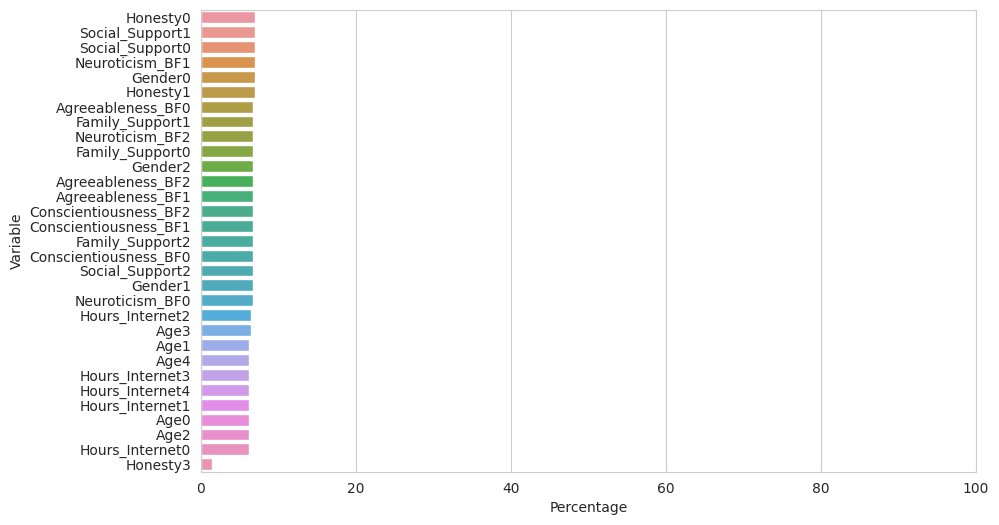

In [40]:
plot_var_count(df=df_2_join, var='P(Riksy|Evidence)', threshold=0.25)

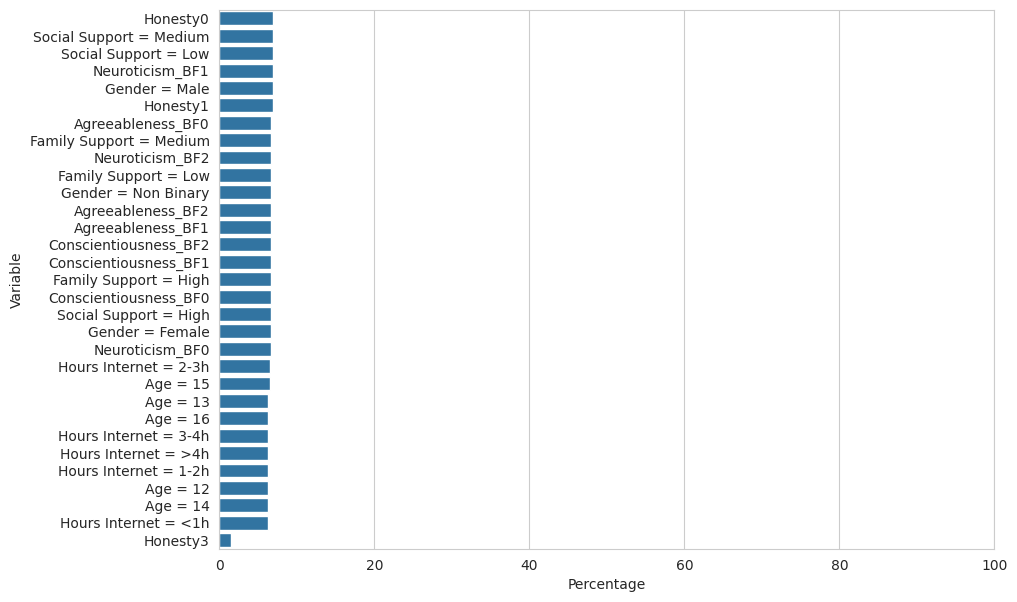

In [41]:
plot_var_count_elegant(df=df_2_join, var='P(Riksy|Evidence)', threshold=0.25)

### 3 variables analysis

In [42]:
df_3_join_ = compute_rank_evidencesv2(3, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_3_join = df_3_join_.sort_values(by=['P(Riksy|Evidence)'])
df_3_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Honesty2, Hours_Internet1, Neuroticism_BF0)",0.059340,0.029406,0.201800
"(Age1, Gender1, Honesty2)",0.059041,0.029105,0.202853
"(Gender1, Honesty2, Hours_Internet1)",0.072954,0.035918,0.203110
"(Honesty2, Hours_Internet1, Social_Support2)",0.092632,0.045405,0.204011
"(Age1, Honesty2, Hours_Internet1)",0.033039,0.016193,0.204030
...,...,...,...
"(Age3, Agreeableness_BF0, Honesty0)",0.087311,0.016684,0.523334
"(Gender0, Honesty0, Social_Support1)",0.173541,0.033148,0.523536
"(Age3, Honesty0, Hours_Internet2)",0.079665,0.015215,0.523586
"(Age3, Honesty0, Social_Support1)",0.072809,0.013841,0.526042


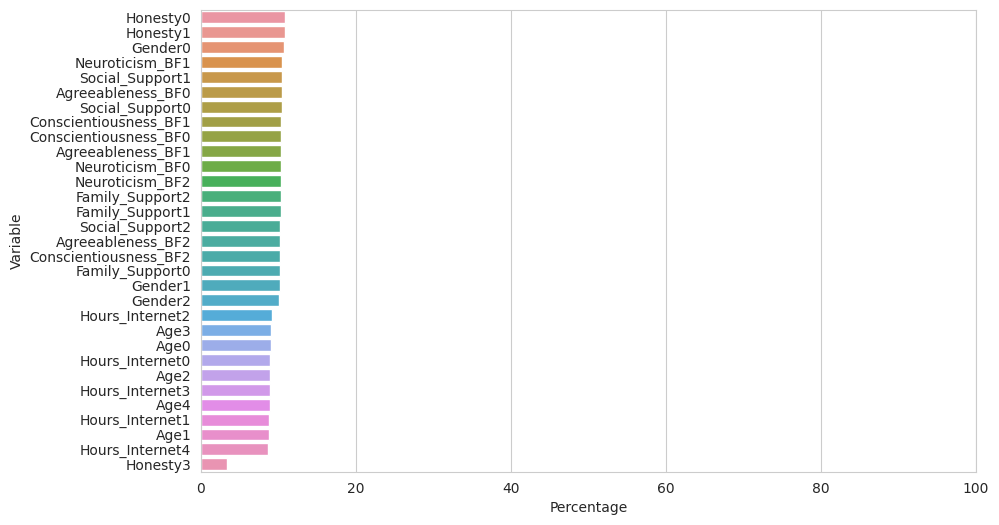

In [43]:
plot_var_count(df=df_3_join, var='P(Riksy|Evidence)', threshold=0.25)

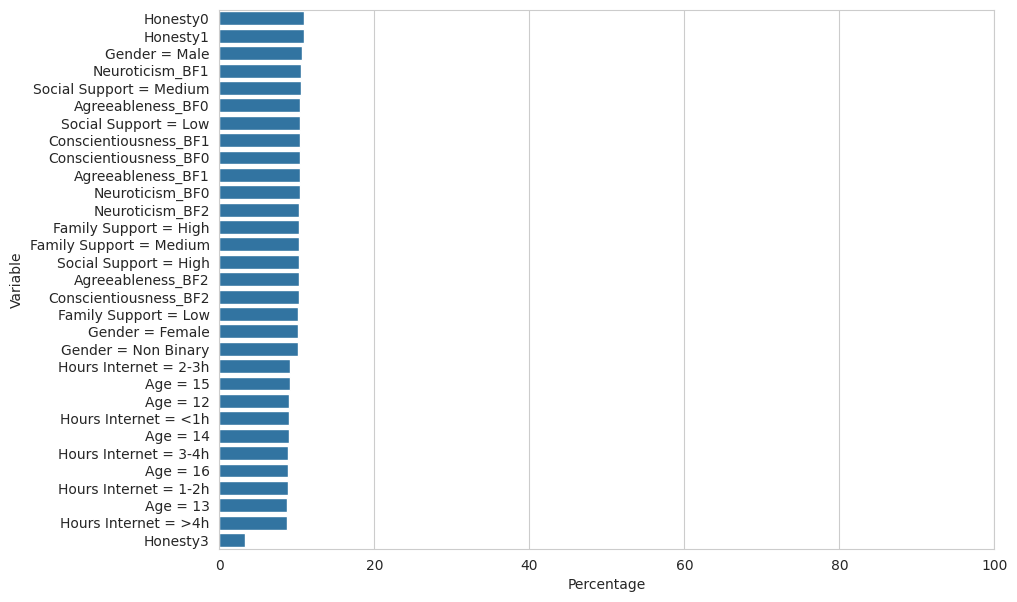

In [44]:
plot_var_count_elegant(df=df_3_join, var='P(Riksy|Evidence)', threshold=0.25)

### 4 variables analysis

In [45]:
df_4_join_ = compute_rank_evidencesv2(4, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_4_join = df_4_join_.sort_values(by=['P(Riksy|Evidence)'])
df_4_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age1, Conscientiousness_BF1, Honesty2, Hours_Internet1)",0.013892,0.007325,0.189658
"(Age0, Conscientiousness_BF0, Honesty2, Hours_Internet1)",0.012666,0.006663,0.190095
"(Age1, Gender1, Honesty2, Hours_Internet1)",0.013981,0.007352,0.190161
"(Honesty2, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.033447,0.017555,0.190531
"(Agreeableness_BF1, Honesty2, Hours_Internet1, Neuroticism_BF0)",0.024304,0.012468,0.194933
...,...,...,...
"(Age1, Gender0, Honesty0, Social_Support1)",0.036558,0.006738,0.542577
"(Age3, Gender0, Honesty0, Neuroticism_BF1)",0.049373,0.009083,0.543570
"(Age3, Gender0, Honesty0, Social_Support1)",0.036732,0.006748,0.544331
"(Gender0, Honesty0, Hours_Internet2, Neuroticism_BF1)",0.083907,0.015395,0.545036


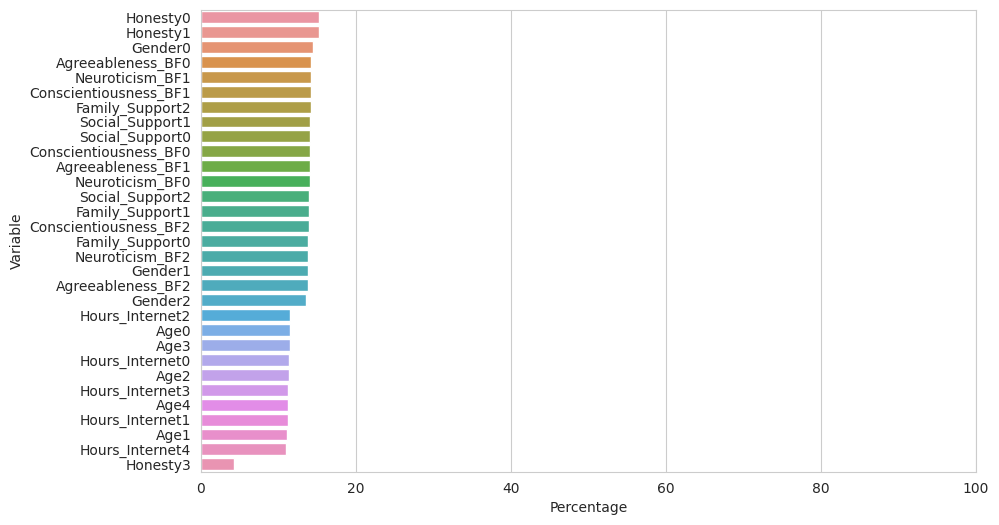

In [46]:
plot_var_count(df=df_4_join, var='P(Riksy|Evidence)', threshold=0.25)

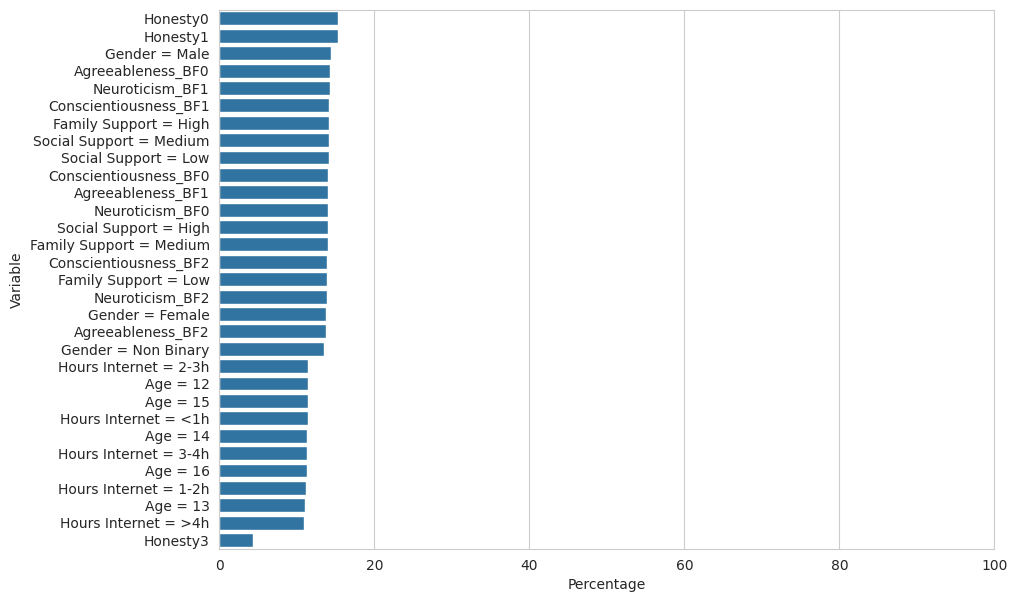

In [47]:
plot_var_count_elegant(df=df_4_join, var='P(Riksy|Evidence)', threshold=0.25)

### 5 variables analysis

In [48]:
df_5_join_ = compute_rank_evidencesv2(5, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_5_join = df_5_join_.sort_values(by=['P(Riksy|Evidence)'])
df_5_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age0, Conscientiousness_BF0, Gender0, Honesty2, Hours_Internet1)",0.005782,0.003271,0.176765
"(Age1, Agreeableness_BF0, Conscientiousness_BF1, Honesty2, Hours_Internet1)",0.005765,0.003248,0.177509
"(Age1, Agreeableness_BF1, Gender1, Honesty2, Hours_Internet1)",0.005552,0.003127,0.177581
"(Age0, Honesty2, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.009196,0.005169,0.177903
"(Agreeableness_BF1, Honesty2, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.013310,0.007464,0.178319
...,...,...,...
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty0)",0.003444,0.000602,0.571657
"(Age0, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2)",0.008318,0.001448,0.574429
"(Age4, Conscientiousness_BF0, Gender0, Honesty0, Hours_Internet3)",0.010111,0.001748,0.578285
"(Age3, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF1)",0.022258,0.003837,0.580120


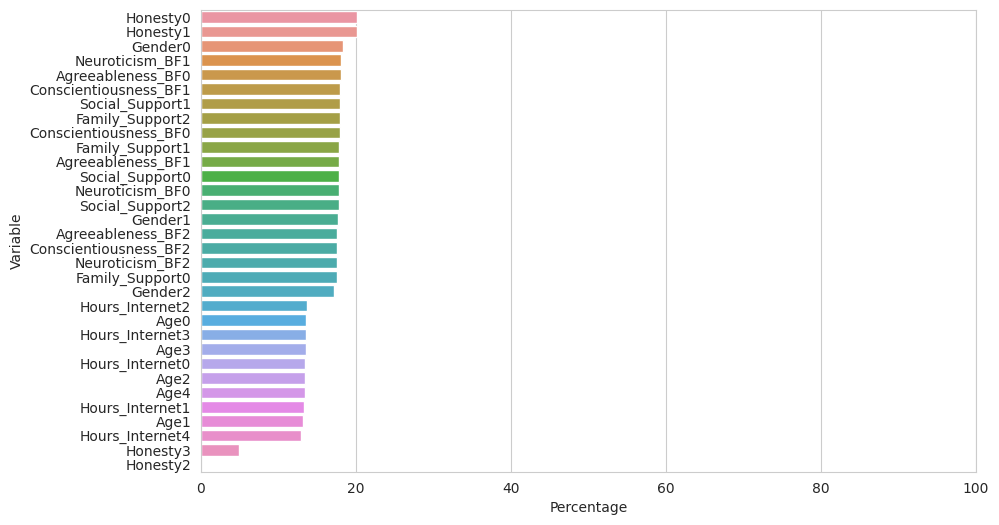

In [49]:
plot_var_count(df=df_5_join, var='P(Riksy|Evidence)', threshold=0.25)

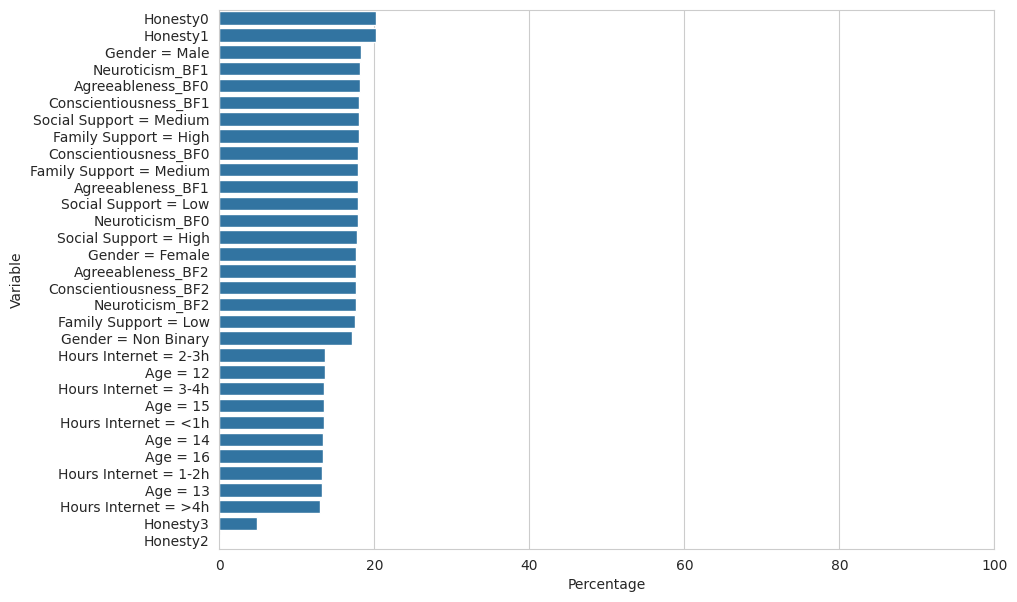

In [50]:
plot_var_count_elegant(df=df_5_join, var='P(Riksy|Evidence)', threshold=0.25)

In [51]:
# all_indexes = []
# for i in df_5_join[df_5_join['P(Riksy|Evidence)']>0.25].index:
#   all_indexes.extend(i)

# len_df_filtered = len(df_5_join[df_5_join['P(Riksy|Evidence)']>0.25])
# lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
# df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
# df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

# lst_vars = ['Previous_Victimization = True',
#             'Gender = Male',
#             'Self-Esteem = High',
#             'Hours of Internet = 3-4 h',
#             'Age = 14',
#             'Age = 16',
#             'Age = 13',
#             'Hours of Internet = >4 h',
#             'Empathy = High',
#             'Family Support = High',
#             'Empathy = Low',
#             'Self-Esteem = Low',
#             'Self-Esteem = Medium',
#             'Hours of Internet = <1 h',
#             'Social Support = High',
#             'Social Support = Medium',
#             'Hours of Internet = 2-3 h',
#             'Family Support = Medium',
#             'Age = 15',
#             'Family Support = Low',
#             'Social Support = Low',
#             'Migratory Background = False',
#             'Sexual Orientation = Heterosexual',
#             'Age = 12',
#             'Gender = Female',
#             'Hours of Internet = 1-2 h'
#             ]


# plt.figure(figsize=(10, 6))
# sns.barplot(data=df_count, x='Percentage', y=lst_vars, color='tab:blue')
# plt.xlim((0,100))

# plt.savefig("5_Factors.pdf", format="pdf", bbox_inches="tight")
# plt.show()
# plt.show()

### 6 variables analysis

In [52]:
df_6_join_ = compute_rank_evidencesv2(6, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_6_join = df_6_join_.sort_values(by=['P(Riksy|Evidence)'])
df_6_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender0, Honesty2, Neuroticism_BF0)",0.003324,0.002176,0.152766
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Honesty2, Hours_Internet2, Neuroticism_BF0)",0.002825,0.001819,0.155318
"(Age3, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet1, Neuroticism_BF0)",0.001620,0.001023,0.158393
"(Age3, Conscientiousness_BF1, Gender0, Honesty2, Neuroticism_BF0, Social_Support2)",0.004614,0.002898,0.159198
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Honesty2, Neuroticism_BF0)",0.004308,0.002692,0.160021
...,...,...,...
"(Age3, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Social_Support2)",0.006055,0.000962,0.629423
"(Age1, Agreeableness_BF1, Conscientiousness_BF2, Honesty0, Hours_Internet1, Social_Support1)",0.002376,0.000375,0.633192
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Honesty0, Hours_Internet2, Social_Support2)",0.001647,0.000260,0.633512
"(Age4, Conscientiousness_BF0, Gender0, Honesty0, Hours_Internet3, Neuroticism_BF0)",0.004496,0.000707,0.635720


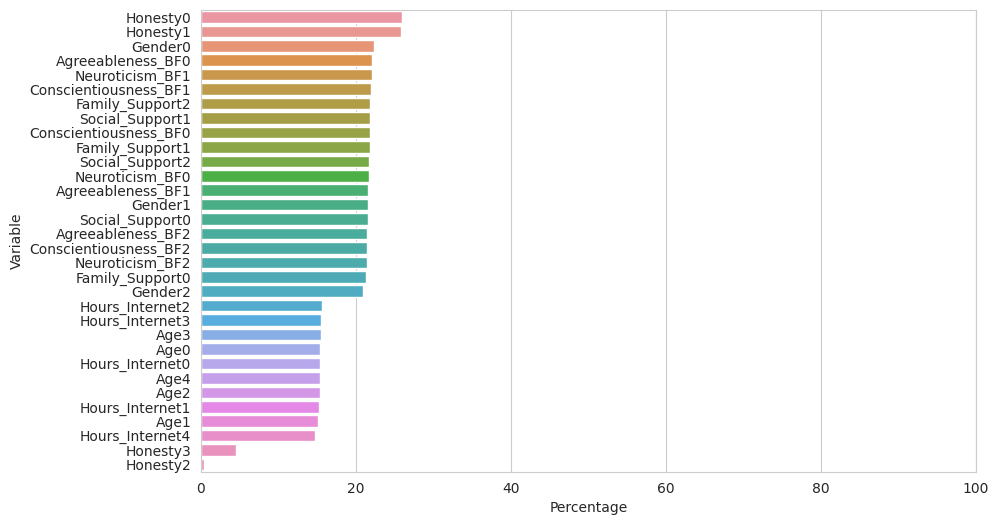

In [53]:
plot_var_count(df=df_6_join, var='P(Riksy|Evidence)', threshold=0.25)

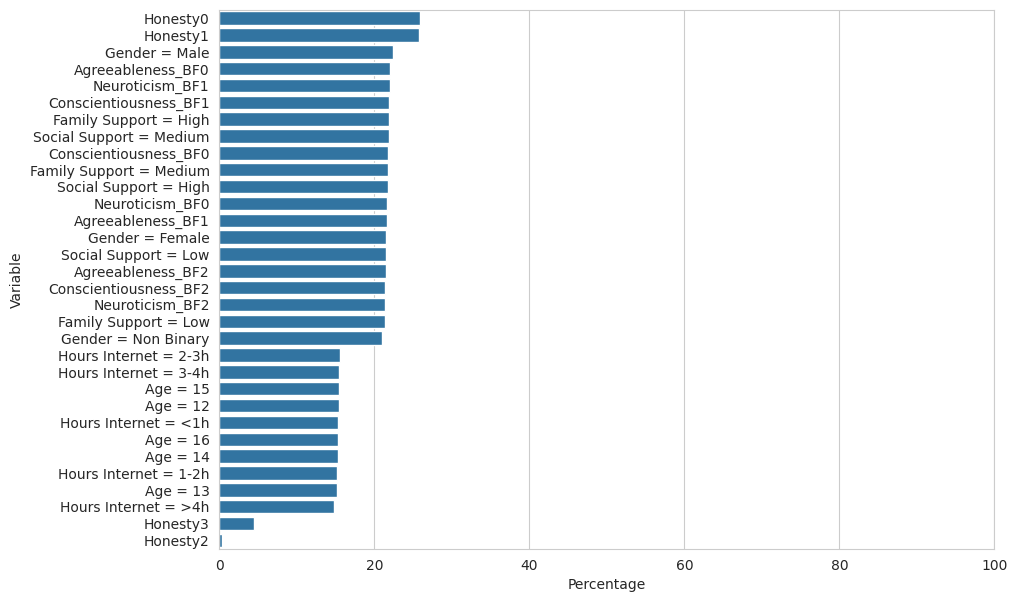

In [54]:
plot_var_count_elegant(df=df_6_join, var='P(Riksy|Evidence)', threshold=0.25)

### 7 variables analysis

In [55]:
df_7_join_ = compute_rank_evidencesv2(7, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_7_join = df_7_join_.sort_values(by=['P(Riksy|Evidence)'])
df_7_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0)",0.001057,0.000908,0.116459
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Neuroticism_BF0)",0.001786,0.001438,0.124218
"(Age3, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.001390,0.001083,0.128366
"(Age3, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Neuroticism_BF0, Social_Support2)",0.002513,0.001915,0.131254
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.001246,0.000929,0.134140
...,...,...,...
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Honesty0, Neuroticism_BF1, Social_Support0)",0.000247,0.000034,0.725020
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF0)",0.000639,0.000088,0.726475
"(Age3, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.003777,0.000519,0.727002
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Social_Support2)",0.001054,0.000143,0.735622


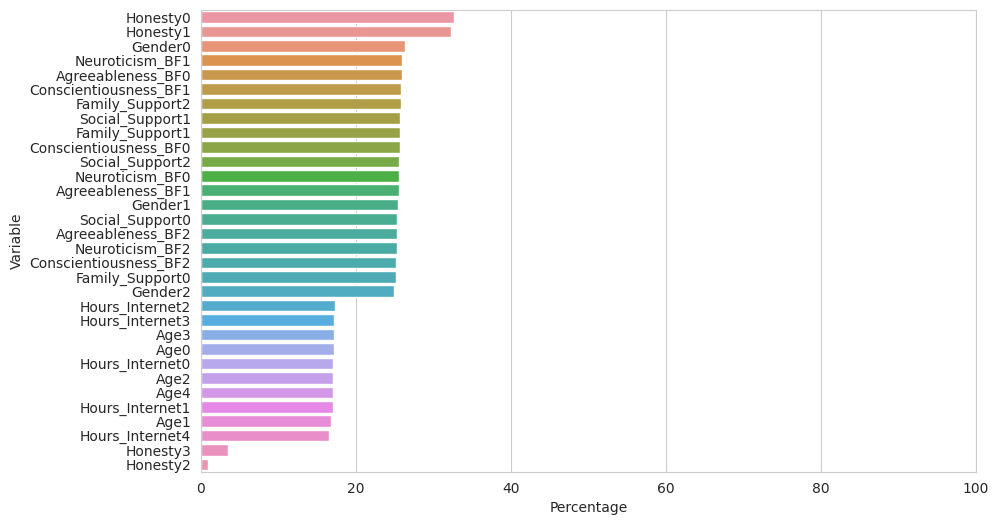

In [56]:
plot_var_count(df=df_7_join, var='P(Riksy|Evidence)', threshold=0.25)

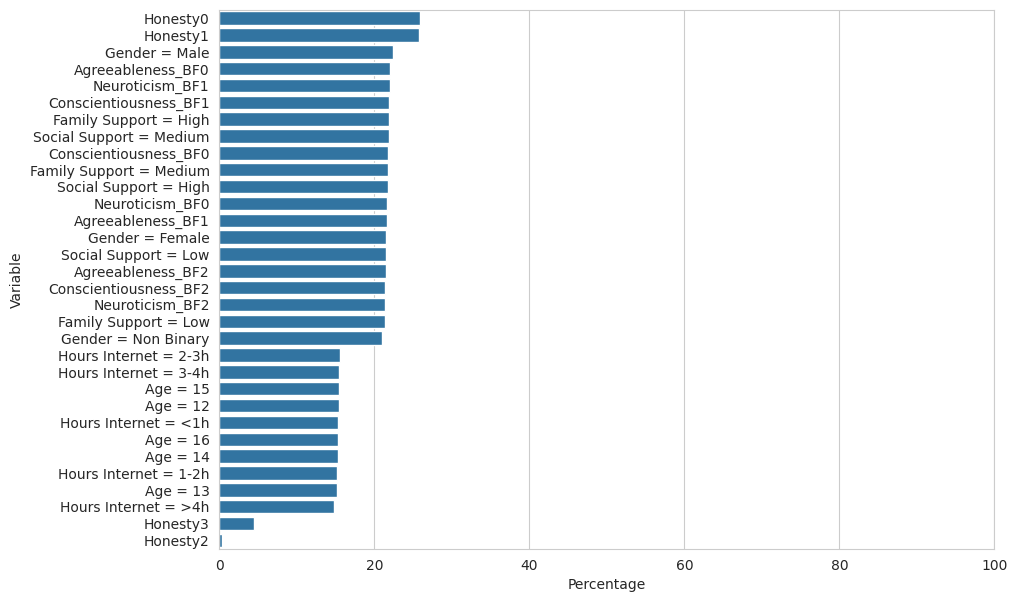

In [57]:
plot_var_count_elegant(df=df_6_join, var='P(Riksy|Evidence)', threshold=0.25)

### 8 variables analysis

In [58]:
df_8_join_ = compute_rank_evidencesv2(8, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_8_join = df_8_join_.sort_values(by=['P(Riksy|Evidence)'])
df_8_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.000436,0.000466,0.093613
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender1, Honesty2, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.000582,0.000573,0.101575
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Neuroticism_BF0, Social_Support2)",0.000841,0.000822,0.102293
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender1, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.001408,0.001357,0.103803
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0)",0.000734,0.000707,0.103939
...,...,...,...
"(Age3, Agreeableness_BF1, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.001751,0.000229,0.765969
"(Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Gender0, Honesty0, Hours_Internet0, Neuroticism_BF1, Social_Support0)",0.000081,0.000011,0.768701
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Honesty0, Hours_Internet0, Neuroticism_BF1, Social_Support0)",0.000156,0.000020,0.768787
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.000442,0.000057,0.773196


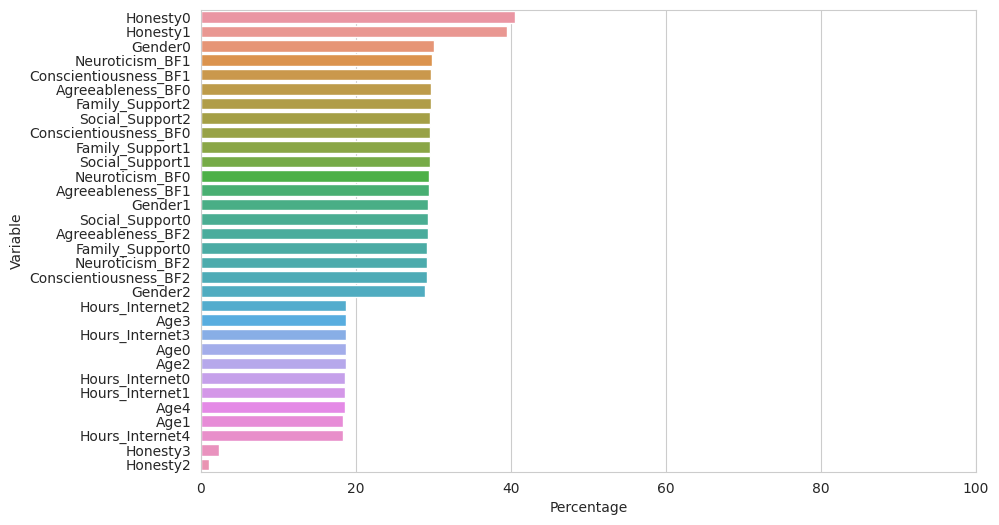

In [59]:
plot_var_count(df=df_8_join, var='P(Riksy|Evidence)', threshold=0.25)

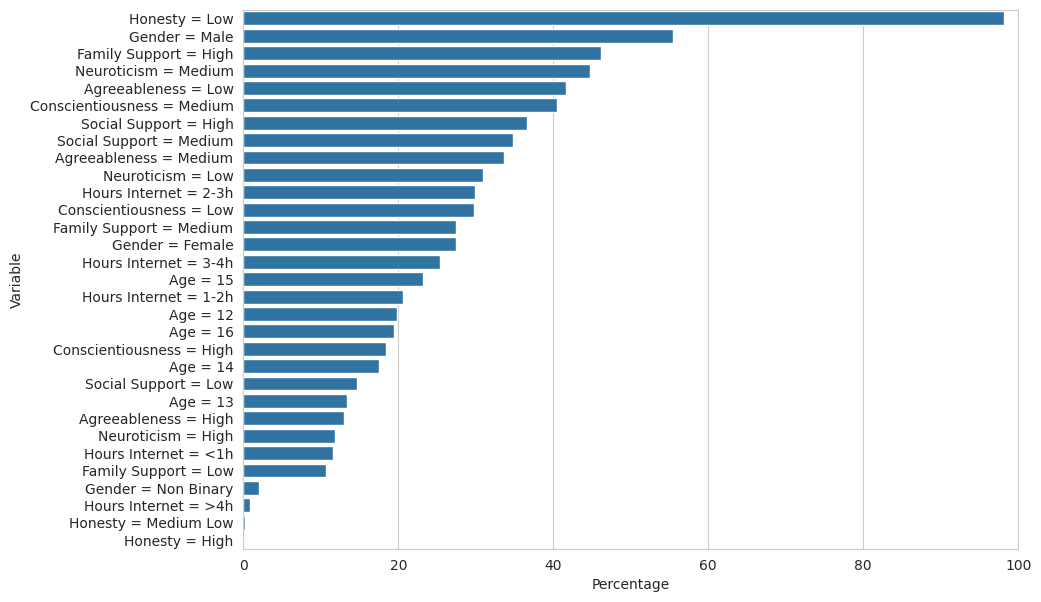

In [105]:
plot_var_count_elegant(df=df_8_join, var='P(Riksy|Evidence)', threshold=0.57)

### 9 variables analysis

In [61]:
df_9_join_ = compute_rank_evidencesv2(9, dict_val_CT,
                                      network_file_CT, var_interest_CT)
df_9_join = df_9_join_.sort_values(by=['P(Riksy|Evidence)'])
df_9_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender1, Honesty2, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.000303,0.000442,0.068455
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.000302,0.000403,0.074862
"(Age2, Agreeableness_BF1, Conscientiousness_BF2, Family_Support2, Gender0, Honesty2, Hours_Internet3, Neuroticism_BF0, Social_Support2)",0.000113,0.000140,0.080806
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender1, Honesty3, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.000222,0.000271,0.081637
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Family_Support2, Gender1, Honesty2, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.000051,0.000057,0.087918
...,...,...,...
"(Age1, Agreeableness_BF0, Conscientiousness_BF1, Family_Support1, Gender1, Honesty0, Hours_Internet0, Neuroticism_BF1, Social_Support0)",0.000163,0.000020,0.812706
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Gender1, Honesty0, Hours_Internet1, Neuroticism_BF1, Social_Support0)",0.000051,0.000006,0.815359
"(Age1, Agreeableness_BF1, Conscientiousness_BF2, Family_Support1, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF0, Social_Support1)",0.000208,0.000025,0.815995
"(Age1, Agreeableness_BF1, Conscientiousness_BF2, Family_Support2, Gender0, Honesty0, Hours_Internet1, Neuroticism_BF0, Social_Support1)",0.000734,0.000088,0.835340


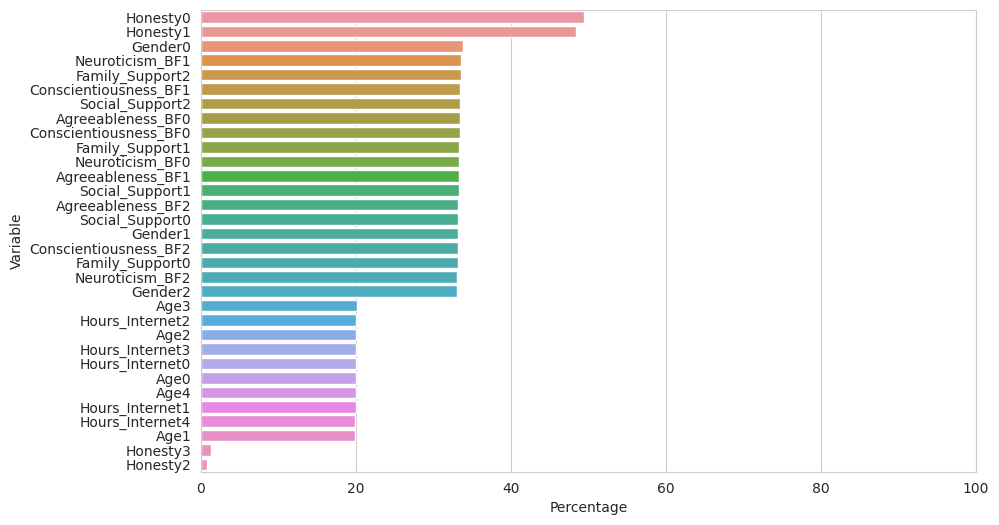

In [62]:
plot_var_count(df=df_9_join, var='P(Riksy|Evidence)', threshold=0.25)

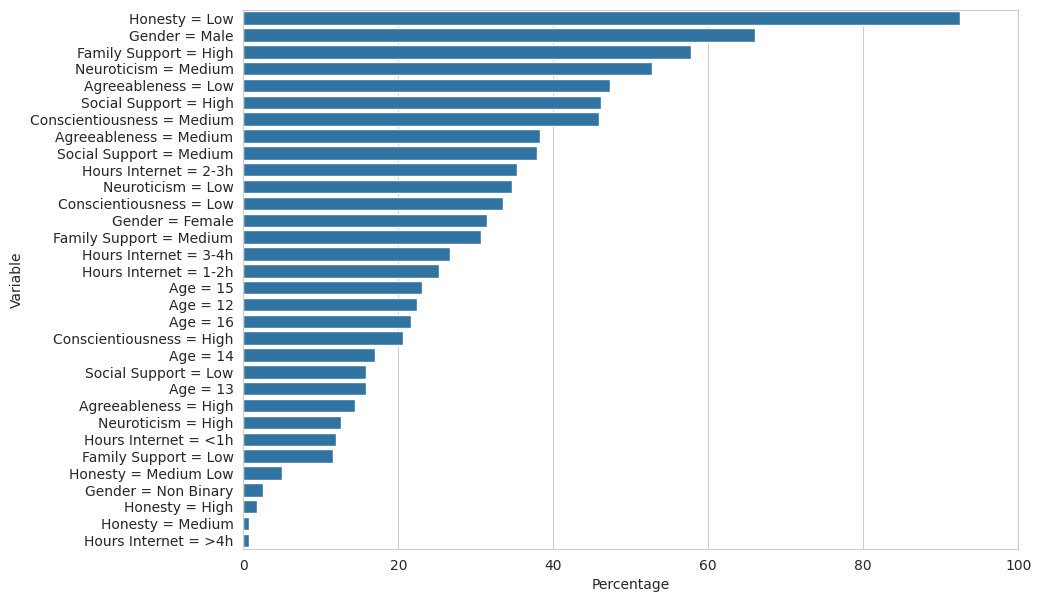

In [103]:
plot_var_count_elegant(df=df_9_join, var='P(Riksy|Evidence)', threshold=0.57)

# Plot

## Max P(Riksy|Evidence) // Nº Var

In [64]:
q_max = []
for i in range(1, 7):
  q_max.append(float(globals()[f'df_q_{i}_join'].tail(1)['P(Riksy|Evidence)']))

dict_q = {'Max': q_max,
          'Data Type': ['Game Questions']*6,
          'vars': list(range(1, 7))}

q_max_evidence = []
for i in range(1, 7):
  q_max_evidence.append(float(globals()[f'df_q_{i}_join'].tail(1)['P(Evidence|Risky)']))

dict_q_evidence = {'Max': q_max_evidence,
                  'Data Type': ['Game P(Evidence|Risky)']*6,
                  'vars': list(range(1, 7))}

In [65]:
dem_max = []
for i in range(1, 10):
  dem_max.append(float(globals()[f'df_{i}_join'].tail(1)['P(Riksy|Evidence)']))

dict_dem = {'Max': dem_max,
            'Data Type': ['Profiling']*9,
            'vars': list(range(1, 10))}

dem_max_evidence = []
for i in range(1, 10):
  dem_max_evidence.append(float(globals()[f'df_{i}_join'].tail(1)['P(Evidence|Risky)']))

dict_dem_evidence = {'Max': dem_max_evidence,
                    'Data Type': ['Profiling P(Evidence|Risky)']*9,
                    'vars': list(range(1, 10))}

In [66]:
dict_dem

{'Max': [0.5095019142820999,
  0.5173305382404895,
  0.5298538733434174,
  0.5456118094383764,
  0.5982509199695246,
  0.6762426684157838,
  0.7535886377852551,
  0.8281961199975796,
  0.8502102434034206],
 'Data Type': ['Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling'],
 'vars': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [67]:
df_max = pd.concat([pd.DataFrame(dict_q),
                    # pd.DataFrame(dict_q_evidence),
                    pd.DataFrame(dict_dem),
                    # pd.DataFrame(dict_dem_evidence)
                    ], ignore_index=True)
df_max

,Max,Data Type,vars
0,0.941407,Game Questions,1
1,0.991115,Game Questions,2
2,0.997620,Game Questions,3
3,0.998698,Game Questions,4
4,0.999244,Game Questions,5
5,0.999491,Game Questions,6
6,0.509502,Profiling,1
7,0.517331,Profiling,2
8,0.529854,Profiling,3
9,0.545612,Profiling,4


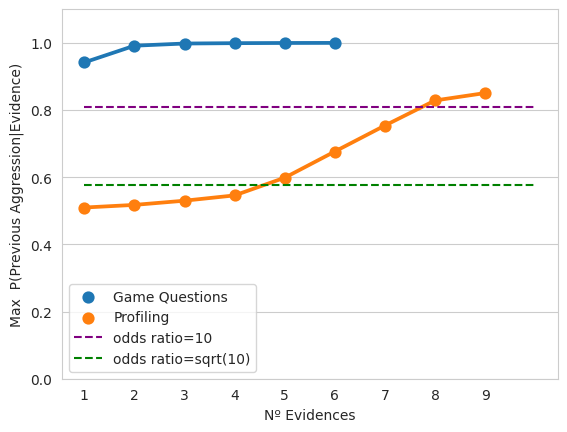

In [106]:
sns.pointplot(df_max, x='vars', y='Max', hue='Data Type')
plt.ylabel('Max  P(Previous Aggression|Evidence)')
plt.hlines(0.81, 0, 9, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.5754, 0, 9, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.xlabel('Nº Evidences')
plt.ylim((0,1.1))
plt.legend(loc='lower left')
plt.savefig("Analysis2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [69]:
df_max_2 = pd.concat([pd.DataFrame(dict_q),
                    pd.DataFrame(dict_dem)], ignore_index=True)
df_max_2

,Max,Data Type,vars
0,0.941407,Game Questions,1
1,0.991115,Game Questions,2
2,0.997620,Game Questions,3
3,0.998698,Game Questions,4
4,0.999244,Game Questions,5
5,0.999491,Game Questions,6
6,0.509502,Profiling,1
7,0.517331,Profiling,2
8,0.529854,Profiling,3
9,0.545612,Profiling,4


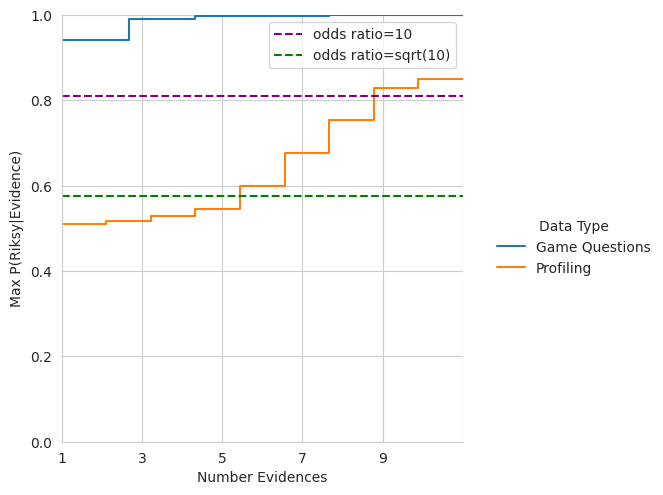

In [70]:
sns.displot(df_max_2, y='Max', hue='Data Type', kind='ecdf')
plt.hlines(0.81, 0, 1, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.5754, 0, 1, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.ylabel('Max P(Riksy|Evidence)')
plt.xlabel('Number Evidences')
plt.ylim((0,1))
ticks, labels = plt.xticks()
labels = [1, 3, 5, 7, 9, '']
plt.xticks(ticks, labels)
plt.legend()
plt.savefig("Analysis2_stair.pdf", format="pdf", bbox_inches="tight")

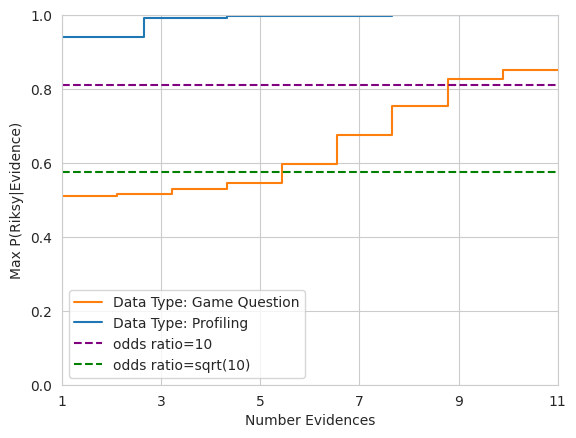

In [71]:
sns.ecdfplot(df_max_2, y='Max', hue='Data Type')
plt.hlines(0.81, 0, 1, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.5754, 0, 1, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.ylabel('Max P(Riksy|Evidence)')
plt.xlabel('Number Evidences')
plt.ylim((0,1))
ticks, labels = plt.xticks()
labels = [1, 3, 5, 7, 9, 11]
plt.xticks(ticks, labels)
plt.legend(['Data Type: Game Question', 'Data Type: Profiling', 'odds ratio=10', 'odds ratio=sqrt(10)'])
plt.savefig("Analysis2_stair.pdf", format="pdf", bbox_inches="tight")

## Max P(Evidence|Riksy) // Nº Var

In [72]:
q_max_2 = []
for i in range(1, 7):
  q_max_2.append(float(globals()[f'df_q_{i}_join']['P(Evidence|Risky)'].max()))

dict_q_2 = {'Max': q_max_2,
          'Type': ['Game Question']*6,
          'vars': list(range(1, 7))}


In [73]:
dem_max_2 = []
for i in range(1, 10):
  dem_max_2.append(float(globals()[f'df_{i}_join']['P(Evidence|Risky)'].max()))

dict_dem_2 = {'Max': dem_max_2,
            'Type': ['Demographic']*9,
            'vars': list(range(1, 10))}

In [74]:
df_max_2 = pd.concat([pd.DataFrame(dict_q_2),
                    pd.DataFrame(dict_dem_2)], ignore_index=True)
df_max_2

,Max,Type,vars
0,1.999321,Game Question,1
1,1.112245,Game Question,2
2,0.605895,Game Question,3
3,0.311323,Game Question,4
4,0.157276,Game Question,5
5,0.064081,Game Question,6
6,1.922039,Demographic,1
7,1.079488,Demographic,2
8,0.587650,Demographic,3
9,0.296915,Demographic,4


(0.0, 1.0)

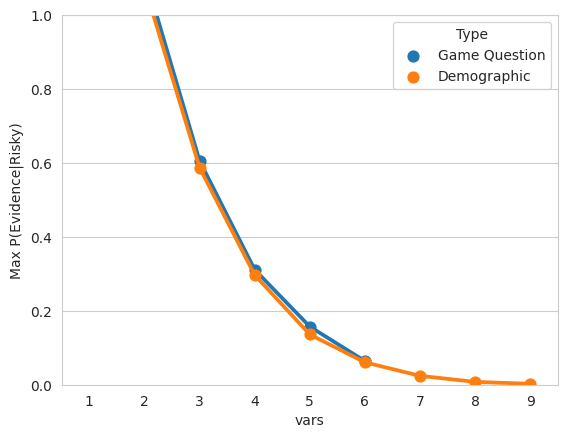

In [75]:
sns.pointplot(df_max_2, x='vars', y='Max', hue='Type')
plt.ylabel('Max P(Evidence|Risky)')
plt.ylim((0,1))

## % risky // Nº Var

In [76]:
threshold_risky = 0.25

In [77]:
import math

In [78]:
q_len = []
for i in range(1, 7):
  _df = globals()[f'df_q_{i}_join']
  len_total = len(_df)
  len_risky = len(_df[_df['P(Riksy|Evidence)']>threshold_risky])
  q_len.append(len_risky/len_total)

dict_q_len = {'Percent': q_len,
          'Type': ['Game Question']*6}

In [79]:
dem_len = []
for i in range(1, 10):
  _df = globals()[f'df_{i}_join']
  len_total = len(_df)
  len_risky = len(_df[_df['P(Riksy|Evidence)']>threshold_risky])
  dem_len.append(len_risky/len_total)

dict_dem_len = {'Percent': dem_len,
          'Type': ['Demographic']*9}

In [80]:
'''comb_max = []
for i in range(1, 11):
  comb_max.append(float(globals()[f'df_comb_{i}'].max()))

dict_comb = {'Max': comb_max,
            'Type': ['Combine']*10}'''

"comb_max = []\nfor i in range(1, 11):\n  comb_max.append(float(globals()[f'df_comb_{i}'].max()))\n\ndict_comb = {'Max': comb_max,\n            'Type': ['Combine']*10}"

In [81]:
df_len = pd.concat([pd.DataFrame(dict_q_len), pd.DataFrame(dict_dem_len)], ignore_index=True)
df_len

,Percent,Type
0,0.571429,Game Question
1,0.703704,Game Question
2,0.693548,Game Question
3,0.714623,Game Question
4,0.744792,Game Question
5,0.736111,Game Question
6,0.937500,Demographic
7,0.889381,Demographic
8,0.844324,Demographic
9,0.792403,Demographic


(0.0, 1.0)

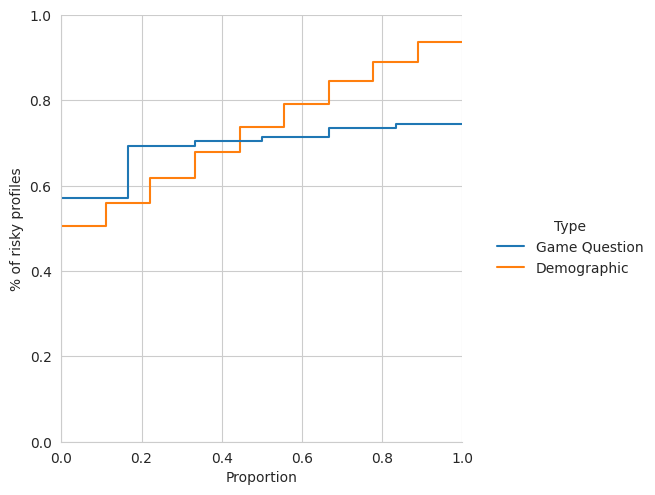

In [82]:
sns.displot(df_len, y='Percent', hue='Type', kind='ecdf')
plt.ylabel('% of risky profiles')
plt.ylim((0,1))